In [20]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import c, epsilon_0, hbar, h
from matplotlib.animation import FuncAnimation, PillowWriter

In [52]:
class BalancedHomodyne:
    def __init__(self, 
                 central_wavelength=1550e-9, # m
                 average_power_lo=1e-6, # W
                 average_power_signal=1e-7, # W
                 repetition_rate=61e6, # Hz
                 temporal_width_lo=300e-15, # s
                 temporal_width_signal=300e-15, # s
                 cross_area=np.pi*1e-6, # m^2
                 time_window=6000e-15, # s
                 grid_points=5000):
        
        self.central_wavelength = central_wavelength
        self.average_power_lo = average_power_lo
        self.average_power_signal = average_power_signal
        self.repetition_rate = repetition_rate
        self.temporal_width_lo = temporal_width_lo
        self.temporal_width_signal = temporal_width_signal
        self.cross_area = cross_area
        self.time_window = time_window
        self.grid_points = grid_points

        # Time array
        self.time_grid = np.linspace(-self.time_window/2, self.time_window/2, self.grid_points)

    def calculate_photon_statistics(self, average_power):
        energy_per_photon = h * c / self.central_wavelength
        print(f"Enertgy per photon : {energy_per_photon}")
        energy_per_pulse = average_power / self.repetition_rate
        print(f"Enertgy per pulse : {energy_per_pulse}")
        average_photons_per_pulse = energy_per_pulse / energy_per_photon
        print(f"Average photons per pulse : {average_photons_per_pulse}")
        photons_per_second = average_photons_per_pulse * self.repetition_rate
        print(f"Photons per second : {average_photons_per_pulse}")

        return energy_per_photon, energy_per_pulse, average_photons_per_pulse, photons_per_second

    def calculate_field_amplitude(self, average_power, temporal_width):
        energy_per_pulse = average_power / self.repetition_rate
        peak_power = (2 * energy_per_pulse) / (temporal_width * np.sqrt(np.pi / np.log(2)))
        field_amplitude = np.sqrt((2 * peak_power) / (c * epsilon_0 * self.cross_area))

        return field_amplitude

    def calculate_phase_shift(self, opd):
        phase_shift = (2 * np.pi / self.central_wavelength) * opd
        return phase_shift

    def distort_pulse_spectrum(self, t, pulse, bandwidth, distortion_function):
        central_omega = 2 * np.pi * c / self.central_wavelength
        bandwidth_omega = 2 * np.pi * c * bandwidth / (self.central_wavelength ** 2 - bandwidth ** 2 / 4)

        E_w = np.fft.fftshift(np.fft.fft(np.fft.ifftshift(pulse)))
        freqs = np.fft.fftshift(np.fft.fftfreq(t.size, d=t[1] - t[0]))
        omega = 2 * np.pi * freqs

        E_w_distorted = E_w * distortion_function(omega, central_omega, bandwidth_omega)
        pulse_distorted = np.fft.fftshift(np.fft.ifft(np.fft.ifftshift(E_w_distorted)))

        return pulse_distorted

    def random_distortion(self, omega, central_omega, bandwidth_omega, phase_variance=1, amplitude_variance=0.1):
        distortion_factor = np.ones_like(omega, dtype=complex)
        lower_bound = central_omega - bandwidth_omega / 2
        upper_bound = central_omega + bandwidth_omega / 2
        within_bandwidth = (omega >= lower_bound) & (omega <= upper_bound)

        distortion_factor[within_bandwidth] *= (
            (1 + np.random.normal(0, amplitude_variance, np.sum(within_bandwidth))) *
            np.exp(1j * np.random.normal(0, phase_variance, np.sum(within_bandwidth)))
        )

        return distortion_factor

    def add_quantum_noise(self, pulse, delay, time_window, average_photons_per_pulse):
        pulse_with_noise = np.copy(pulse)
        noise_indices = np.where(np.abs(self.time_grid - delay) <= time_window / 2)[0]
        omega = 2 * np.pi * c / self.central_wavelength
        mode_volume = self.cross_area * self.central_wavelength
        #quantum_noise = np.sqrt((hbar * omega) / (2 * epsilon_0 * mode_volume))
        quantum_noise = np.sqrt(average_photons_per_pulse)

        pulse_with_noise[noise_indices] += (1 + quantum_noise) * np.exp(1j * quantum_noise)

        return pulse_with_noise

    def apply_gdd_to_pulse(self, pulse, gdd_fs2):
        omega_0 = 2 * np.pi * c / self.central_wavelength
        E_w = np.fft.fftshift(np.fft.fft(np.fft.ifftshift(pulse)))
        freqs = np.fft.fftshift(np.fft.fftfreq(self.time_grid.size, d=self.time_grid[1] - self.time_grid[0]))
        omega = 2 * np.pi * freqs
        phase_shift = 0.5 * gdd_fs2 * 1e-30 * (omega - omega_0) ** 2
        E_w_gdd = E_w * np.exp(1j * phase_shift)
        E_t_gdd = np.fft.fftshift(np.fft.ifft(np.fft.ifftshift(E_w_gdd)))

        return E_t_gdd

    def coherent_pulse(self,
                       field,
                       delay=0, 
                       gdd_fs2=0, 
                       distortion=False, 
                       loss_per_s=0, 
                       offset_loss=0, 
                       distortion_bandwidth=0):
        
        average_power = 0
        temporal_width = 0
        if(field == 'signal'):
            average_power = self.average_power_signal
            temporal_width = self.temporal_width_signal
        else:
            average_power = self.average_power_lo
            temporal_width = self.temporal_width_lo
        _, _, average_photons_per_pulse, _ = self.calculate_photon_statistics(average_power)

        central_frequency = c / self.central_wavelength  # Central frequency of the pulse

        amplitude = self.calculate_field_amplitude(average_power, temporal_width)
        print(f"Field amplitude = {amplitude} V/m")
        # Apply loss factor to the amplitude
        loss_factor = 1 - (loss_per_s * np.abs(delay-offset_loss)/(2*np.pi)) # Calculate loss factor based on delay
        amplitude *= loss_factor

        pulse = np.zeros_like(self.time_grid, dtype=complex)  # Use built-in complex type


        # Generate coherent state pulses over the entire time range according to the repetition period
        #for n in range(int(np.floor(t_seconds[0] / repetition_period)), int(np.ceil(t_seconds[-1] / repetition_period))):
        #pulse_center_seconds = n * repetition_period * 1e-15 + delay * 1e-15  # Convert fs to seconds for calculation
        pulse_center = delay # s
        time_from_center = self.time_grid - pulse_center
        pulse += amplitude * np.exp(-((time_from_center) ** 2) / (2 * temporal_width**2)) * np.exp(1j * (2 * np.pi * central_frequency * time_from_center))
        pulse = np.copy(self.apply_gdd_to_pulse(pulse, gdd_fs2*1e30))

        if(distortion):
            pulse = np.copy(self.distort_pulse_spectrum(self.time_grid, pulse, self.central_wavelength, distortion_bandwidth, self.random_distortion))

        # Quantum noise due to vacuum fluctuations
        pulse = np.copy(self.add_quantum_noise(pulse, delay, 5*temporal_width, average_photons_per_pulse))

        return pulse

    def balanced_homodyne_detection(self, signal_pulse, lo_pulse, electric_noise_level=0.2):
        output_port1 = (signal_pulse + lo_pulse) / np.sqrt(2)
        output_port2 = (signal_pulse - lo_pulse) / np.sqrt(2)
        detector_output = np.abs(output_port1 * np.conj(output_port1)) - np.abs(output_port2 * np.conj(output_port2))

        electric_noise = np.random.normal(-electric_noise_level / 2, electric_noise_level / 2, signal_pulse.shape)
        #detector_output += electric_noise

        #return detector_output
        return np.abs(output_port1 * np.conj(output_port1))
    
    def plot_pulses(self, signal_pulse, lo_pulse, detector_output):
        # Plotting
        plt.figure(figsize=(12, 6))

        # Create the first plot with its own y-axis
        ax1 = plt.gca()  # Get the current Axes instance
        line1, = ax1.plot(self.time_grid, np.abs(signal_pulse)**2, label='Intensity of Chirped Signal Pulse', color='blue')
        ax1.set_xlabel('Time (fs)')
        ax1.set_ylabel('Intensity of Chirped Signal Pulse', color='blue')
        ax1.tick_params(axis='y', labelcolor='blue')
        ax1.grid(True)

        # Create a second y-axis that shares the same x-axis
        ax2 = ax1.twinx()
        line2, = ax2.plot(self.time_grid, np.abs(lo_pulse)**2, label='Intensity of LO Pulse', linestyle='--', color='green')
        ax2.set_ylabel('Intensity of LO Pulse', color='green')
        ax2.tick_params(axis='y', labelcolor='green')

        # Combine legends from both axes
        lines = [line1, line2]
        labels = [line.get_label() for line in lines]
        ax1.legend(lines, labels, loc='upper left')

        plt.title('Coherent State Pulses')

        # Plotting
        plt.figure(figsize=(12, 6))
        plt.plot(self.time_grid, detector_output, label='Balanced Homodyne Detection Output')
        plt.title('Balanced Homodyne Detection Simulation')
        plt.xlabel('Time (s)')
        plt.ylabel('Detector Output')
        plt.grid(True)
        plt.legend()
        plt.show()

    def animate_pulses(self, optical_path_difference):
        # Prepare the figure and axes for the animation
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))
        line1, = ax1.plot([], [], label='Signal Pulse')
        line2, = ax1.plot([], [], label='LO Pulse', linestyle='--')
        line3, = ax2.plot([], [], label='Balanced Homodyne Output')
        ax1.set_xlim(self.time_grid[0], self.time_grid[-1])
        ax1.set_ylim(-0.1, 0.2)
        ax1.set_title('Coherent State Pulses')
        ax1.set_xlabel('Time (fs)')
        ax1.set_ylabel('Intensity')
        ax1.legend()
        ax1.grid(True)
        ax2.set_xlim(self.time_grid[0], self.time_grid[-1])
        ax2.set_ylim(-1e7, 1.5e9)
        ax2.set_title('Balanced Homodyne Detection Simulation')
        ax2.set_xlabel('Time (fs)')
        ax2.set_ylabel('Detector Output')
        ax2.grid(True)
        ax2.legend()

        def init():
            line1.set_data([], [])
            line2.set_data([], [])
            line3.set_data([], [])
            return line1, line2, line3

        def animate(i):
            opd = optical_path_difference[i]
            delay = opd / c  # Convert OPD to delay in s

            # Generate signal and LO pulses with the current phase shift applied to the LO
            signal_pulse = self.coherent_pulse('signal')
            lo_pulse = self.coherent_pulse('lo', delay=delay)
            detector_output = self.balanced_homodyne_detection(signal_pulse, lo_pulse)

            # Update the plots
            line1.set_data(self.time_grid, np.abs(signal_pulse)**2 / np.linalg.norm(np.abs(signal_pulse)**2))
            line2.set_data(self.time_grid, np.abs(lo_pulse)**2 / np.linalg.norm(np.abs(lo_pulse)**2))
            line3.set_data(self.time_grid, detector_output)

            # Update OPD text
            ax1.text(0.05, 0.95, f'OPD: {opd*1e6:.2f} µm', transform=ax1.transAxes, fontsize=9, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

            return line1, line2, line3

        # Create the animation
        ani = FuncAnimation(fig, animate, frames=len(optical_path_difference), init_func=init, blit=True, interval=50)

        # Save the animation as a GIF
        ani.save('balanced_homodyne_detection.gif', writer='pillow', fps=120)

        plt.show()

cross area : 3.141592653589793e-06
delay = 1.6678204759907604e-12
Enertgy per photon : 1.2815779723541474e-19
Enertgy per pulse : 8.19672131147541e-13
Average photons per pulse : 6395803.835812459
Photons per second : 6395803.835812459
Field amplitude = 30387.454867910063 V/m
Enertgy per photon : 1.2815779723541474e-19
Enertgy per pulse : 3.278688524590164e-11
Average photons per pulse : 255832153.43249837
Photons per second : 255832153.43249837
Field amplitude = 192187.13935633373 V/m


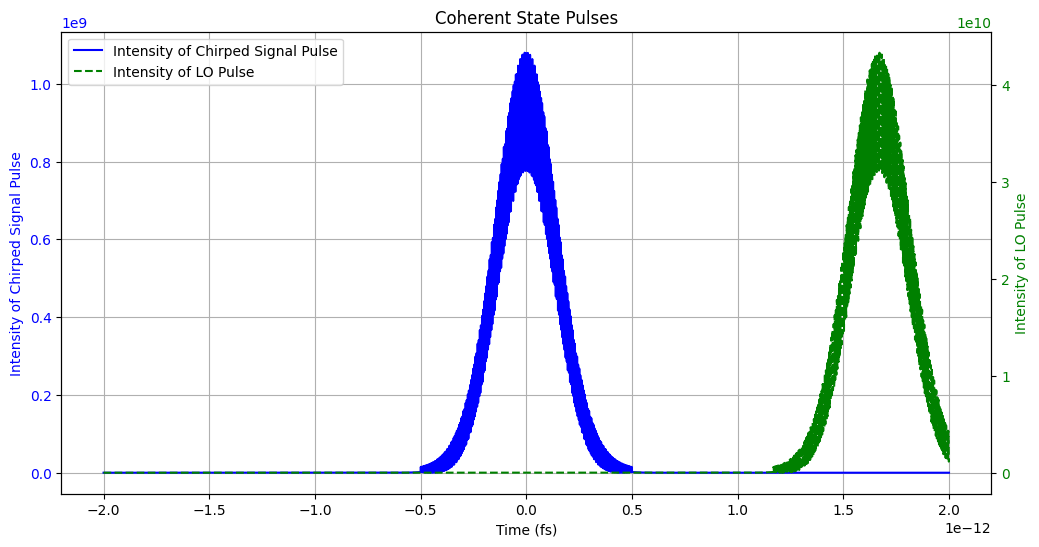

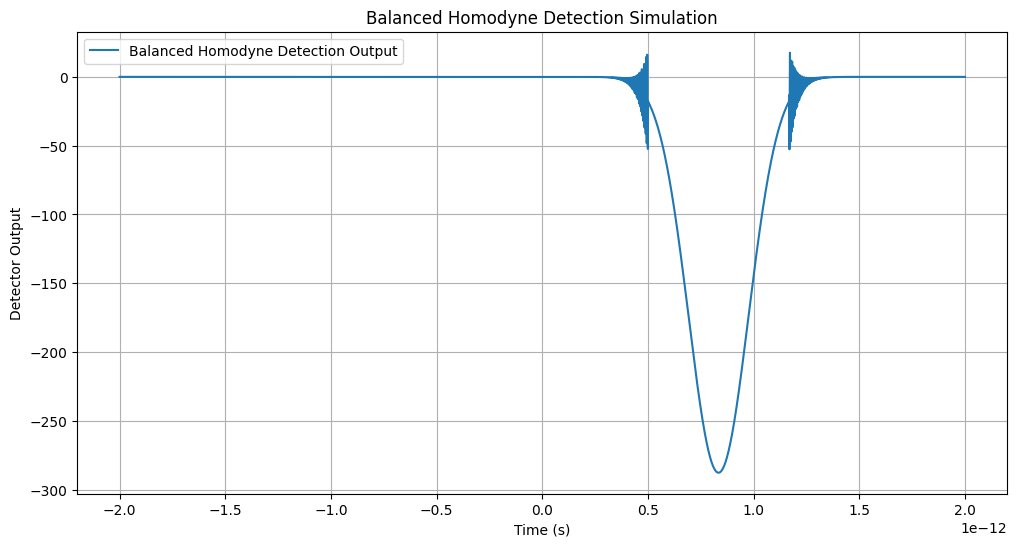

In [53]:
# Given parameters
average_power_signal = 50e-6 # W
average_power_lo = 2e-3 # W
temporal_width_signal = 200e-15  # s
temporal_width_lo = 200e-15  # s
repetition_rate = 61e6  # 61 MHz
central_wavelength = 1550e-9  # 1550 nm
bandwidth = 100e-9  # Bandwidth in meters
beam_radius = 1e-3 # m
cross_area = np.pi*beam_radius**2 # m^2
print(f"cross area : {cross_area}")
gdd_fs2 = 0  # GDD parameter in fs^2
loss_per_fs = 0.1 # Loss factor per femtosecond of delay, representing the linear relationship between delay and losses.
offset_loss = 0 # where the loss_per_fs is equal to zero
opd = 0.00050 # Optical path difference range in meters
delay = opd/c # Temporal delay of the pulse in seconds
print('delay = ' + str(delay))
distortion_signal = False  # apply distortion to signal's spectrum
distortion_lo = False # apply distortion to lo's spectrum

# initialize BHD object
balanced_homodyne = BalancedHomodyne(
    central_wavelength=central_wavelength, # m
    average_power_lo=average_power_lo, # W
    average_power_signal=average_power_signal, # W
    repetition_rate=repetition_rate, # Hz
    temporal_width_lo=temporal_width_lo, # s
    temporal_width_signal=temporal_width_signal, # s
    cross_area=cross_area, # m^2
    time_window=20*temporal_width_lo, # s
    grid_points=5000
    )


# Generate coherent state signal and LO pulses with quantum noise and chirp
signal_pulse = balanced_homodyne.coherent_pulse('signal')
lo_pulse = balanced_homodyne.coherent_pulse('lo', delay=delay)

# Simulate balanced homodyne detection
detector_output = balanced_homodyne.balanced_homodyne_detection(signal_pulse, lo_pulse)

# Plotting
balanced_homodyne.plot_pulses(signal_pulse, lo_pulse, detector_output)

Enertgy per photon : 1.2815779723541474e-19
Enertgy per pulse : 8.19672131147541e-13
Average photons per pulse : 6395803.835812459
Photons per second : 6395803.835812459
Field amplitude = 30387.454867910063 V/m
Enertgy per photon : 1.2815779723541474e-19
Enertgy per pulse : 3.278688524590164e-11
Average photons per pulse : 255832153.43249837
Photons per second : 255832153.43249837
Field amplitude = 192187.13935633373 V/m
Enertgy per photon : 1.2815779723541474e-19
Enertgy per pulse : 8.19672131147541e-13
Average photons per pulse : 6395803.835812459
Photons per second : 6395803.835812459
Field amplitude = 30387.454867910063 V/m
Enertgy per photon : 1.2815779723541474e-19
Enertgy per pulse : 3.278688524590164e-11
Average photons per pulse : 255832153.43249837
Photons per second : 255832153.43249837
Field amplitude = 192187.13935633373 V/m
Enertgy per photon : 1.2815779723541474e-19
Enertgy per pulse : 8.19672131147541e-13
Average photons per pulse : 6395803.835812459
Photons per second 

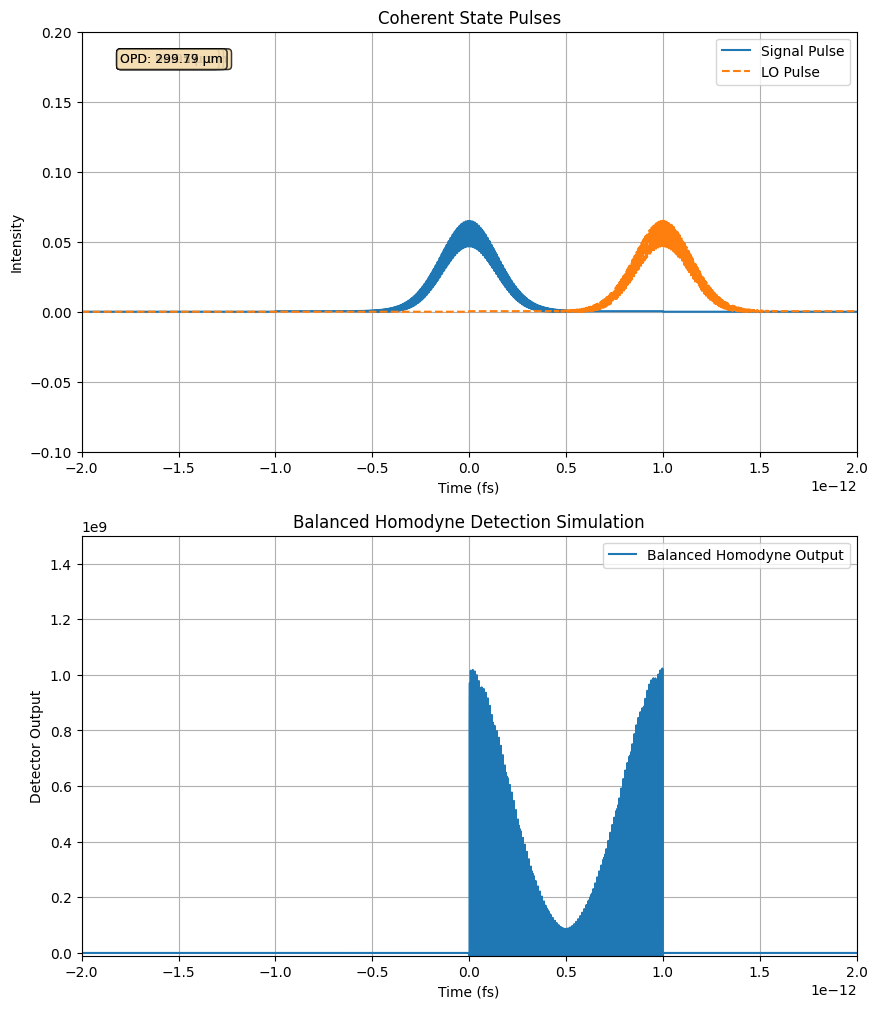

In [41]:
# Optical path differences to explore
opds = np.linspace(-5*temporal_width_lo*c, 5*temporal_width_lo*c, 10)  # meters

balanced_homodyne.animate_pulses(opds)